In [71]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler  

sns.set_style("whitegrid")

In [164]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [165]:
path = 'data/processed'
benchmarks_df = pd.read_csv(os.path.join(path, 'a_benchmarks_2024-09-11.csv'))
schools_df = pd.read_csv(os.path.join(path, 'a_schools_2024-08-29.csv'))
courseSections_df = pd.read_csv(os.path.join(path, 'a_courseSections_2024-08-29.csv'))
courseSectionRosters_df = pd.read_csv(os.path.join(path, 'a_courseSectionRosters_2024-08-29.csv'))
scores_df = pd.read_csv(os.path.join(path, 'a_scores_2024-09-11.csv'))
vendorUsage_df = pd.read_csv(os.path.join(path, 'a_vendorUsage_2024-09-11.csv'))

/var/folders/w3/z8qntdcx62v2qmj6z9fwfhrh0000gp/T/ipykernel_3497/4073666699.py:5: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  courseSectionRosters_df = pd.read_csv(os.path.join(path, 'a_courseSectionRosters_2024-08-29.csv'))


# Preprocess dataframes

## courseSections_df and courseSectionRosters_df

In [166]:
courseSectionRosters_df.drop(columns=['id', 'ticket'], inplace=True)
courses = courseSectionRosters_df.merge(courseSections_df, left_on='courseSectionId', right_on='id', how='left')
courses.drop(columns=['id'], inplace=True)
courses = courses[~courses['vanityId'].str.contains('District Wide', case=False, na=False)]
courses = courses[~courses['vanityId'].str.contains('Schoolwide', case=False, na=False)]

## vendorUsage_df

In [167]:
vendorUsage_df.head()

,id,vendorId,studentId,active,year,usageTypeId,weeklyUsageMinutes
0,11890,72609,44777,0,2018,1,0
1,11891,72609,44783,0,2018,1,0
2,11892,72609,44784,0,2018,1,0
3,11893,72609,44807,0,2018,1,0
4,11894,72609,44809,0,2018,1,0


In [168]:
# Drop unneded columns (vendorId is represented within usageTypeId)
vendorUsage_df.drop(columns=['vendorId', 'active', 'id', 'weeklyUsageMinutes'], inplace=True)
vendorUsage_df.head()

,studentId,year,usageTypeId
0,44777,2018,1
1,44783,2018,1
2,44784,2018,1
3,44807,2018,1
4,44809,2018,1


In [169]:
vendorUsage_df['usageTypeId'].value_counts()

usageTypeId
4     50310
1     47620
3     21983
6     13381
2     10945
5      8014
9      1368
7      1173
12     1117
8       974
10      808
11      273
14       41
Name: count, dtype: int64

**Current usageTypeIds:**
- iReady Math User = 6
- iReady Math Partial = 5
- iReadyMath nonUser = 4
- iReady Reading user = 3
- iReady Reading partial = 2 
- iReady reading nonuser = 1
- BBB Literacy User = 9
- BBB Literacy Partial = 8
- BBB Literacy nonUser = 7
- will drop rest of usageTypeIds (10, 11, 12, 14)

**New mapping:**

`iready_math` (new feature)
- 0 nonUser
- 1 partial
- 2 user

`iready_reading` (new feature)
- 0 nonUser
- 1 partial
- 2 user

`bbb_literacy` (new feature)
- 0 nonUser
- 1 partial
- 2 user

In [170]:
iready_math_mapping = {
    4: 0,  # nonUser
    5: 1,  # partial
    6: 2   # user
}

# Mapping for iReady Reading
iready_reading_mapping = {
    1: 0,  # nonUser
    2: 1,  # partial
    3: 2   # user
}

bbb_literacy_mapping = {
    7: 0,  # nonUser
    8: 1,  # partial
    9: 2   # user
}

vendorUsage_df['iready_math'] = 0
vendorUsage_df['iready_reading'] = 0
vendorUsage_df['bbb_literacy'] = 0

vendorUsage_df['iready_math'] = vendorUsage_df['usageTypeId'].map(iready_math_mapping).fillna(0)
vendorUsage_df['iready_reading'] = vendorUsage_df['usageTypeId'].map(iready_reading_mapping).fillna(0)
vendorUsage_df['bbb_literacy'] = vendorUsage_df['usageTypeId'].map(bbb_literacy_mapping).fillna(0)

vendorUsage_df['iready_math'] = vendorUsage_df['iready_math'].astype(int)
vendorUsage_df['iready_reading'] = vendorUsage_df['iready_reading'].astype(int)
vendorUsage_df['bbb_literacy'] = vendorUsage_df['bbb_literacy'].astype(int)

vendorUsage_df.drop('usageTypeId', axis=1, inplace=True)

vendorUsage_df.shape

(158007, 5)

In [171]:
vendorUsage_df = vendorUsage_df.groupby(['studentId', 'year']).agg({
    'iready_math': 'max',
    'iready_reading': 'max',
    'bbb_literacy': 'max'
}).reset_index()

print("Combining rows with the same studentId and year:")
print(vendorUsage_df.shape)

Combining rows with the same studentId and year:
(71627, 5)


# Create labels 
- `is_proficient` - boolean label representing whether the student's score is above the benchmark score for the given dataSource and year
- `proficient_score` - score / threshold representing the benchmark for proficient
- `proficient_diff` - score - threshold representing the benchmark for proficient

In [172]:
# Step 1: Select only columns starting with 'value_' and keep 'studentId', 'studentLevel', 'year'
value_columns = [col for col in scores_df.columns if col.startswith('value_')]
selected_columns = ['studentId', 'studentLevel', 'year'] + value_columns
scores_subset = scores_df[selected_columns]
scores_subset.head()

,studentId,studentLevel,year,value_actMathScore,value_actEnglishScore,value_actReadingScore,value_actScienceScore,value_actCompositeScore,value_nweaMath,value_nweaReading,value_nweaEnglish,value_iReadyMath,value_iReadyReading,value_actMasteryComposite,value_actMasteryReading,value_actMasteryMath,value_actMasteryScience,value_actMasteryEnglish,value_nweaELA,value_scantronMath,value_scantronReading,value_mapMath,value_mapEnglish,value_mapReading,value_mapRLA,value_scantronScience,value_scantronLanguage,value_ReadingFoundations,value_scantronAlgebra,value_eocMath,value_actELAScore,value_mapScience,value_LeapELAScale,value_LeapMathScale,value_LeapALScale,value_LeapE2Scale,value_LeapGmScale,value_LeapBlScale,value_LeapE3Scale,value_LeapUsScale,value_E1Scale,value_UsEsScale,value_accessReadingScale,value_accessReadingProficiency,value_accessCompositeScale,value_accesscompositeProficiency,value_dibelsReading,value_mapHistory,value_LEAPSocSci,value_scantronGeometry,value_MathMilestones,value_ELAMilestones,value_starReading,value_starMath,value_ScienceMilestones,value_LEAPScience,value_SocialMilestones,value_gcaInfo,value_gcaNar,value_gcaOpin,value_aimsWebMath,value_aimsWebReading
0,44774,9,2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,44774,8,2017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2841.0,2950,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,44774,8,2017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2808.0,2936,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,44775,8,2017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2580.0,2660,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,44775,8,2017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2705.0,2670,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [173]:
# Step 2: Melt the scores_subset to create a long format
scores_long = scores_subset.melt(
    id_vars=['studentId', 'studentLevel', 'year'], 
    var_name='dataSource', 
    value_name='score'
)

scores_long = scores_long[scores_long['score'] != 0]


# Step 3: Rename 'studentLevel' to 'level' to match benchmarks_df
scores_long.rename(columns={'studentLevel': 'level'}, inplace=True)

# Step 4: Remove the 'value_' prefix from the dataSource column
# scores_long['dataSource'] = scores_long['dataSource'].str.replace('value_', '', regex=False)

# Step 5: Drop rows with NaN scores
scores_long.dropna(subset=['score'], inplace=True)

scores_long.head(20)

,studentId,level,year,dataSource,score
1439,45053,11,2017,value_actMathScore,14.0
1440,45054,11,2018,value_actMathScore,9.0
1789,45168,7,2018,value_actMathScore,15.0
2442,45304,7,2018,value_actMathScore,18.0
2968,45440,11,2018,value_actMathScore,16.0
4264,45721,6,2018,value_actMathScore,22.0
4808,45858,11,2017,value_actMathScore,25.0
4809,45859,11,2017,value_actMathScore,34.0
4848,45953,11,2018,value_actMathScore,17.0
4852,45960,11,2017,value_actMathScore,27.0


In [174]:
# Step 6: Merge the long-format scores with the benchmarks
proficiency_melted_df = pd.merge(
    scores_long, 
    benchmarks_df[['year', 'level', 'dataSource', 'value']], 
    on=['year', 'level', 'dataSource'], 
    how='left'
)

# Check for any missing values after the merge
missing_benchmarks = proficiency_melted_df['value'].isna().sum()
print(f"Number of scores without corresponding benchmark: {missing_benchmarks}")

proficiency_melted_df.dropna(subset=['value'], inplace=True)
proficiency_melted_df.head(10)

Number of scores without corresponding benchmark: 417357


,studentId,level,year,dataSource,score,value
1,45054,11,2018,value_actMathScore,9.0,17.0
4,45440,11,2018,value_actMathScore,16.0,17.0
8,45953,11,2018,value_actMathScore,17.0,17.0
11,46042,11,2018,value_actMathScore,17.0,17.0
12,46042,11,2018,value_actMathScore,18.0,17.0
19,46082,11,2018,value_actMathScore,14.0,17.0
36,46177,11,2018,value_actMathScore,14.0,17.0
39,46199,11,2018,value_actMathScore,16.0,17.0
56,46273,11,2018,value_actMathScore,14.0,17.0
62,46313,11,2018,value_actMathScore,14.0,17.0


In [175]:
# Step 7: Create the proficiency labels
proficiency_melted_df['is_proficient'] = proficiency_melted_df['score'] >= proficiency_melted_df['value']
proficiency_melted_df['proficient_score'] = proficiency_melted_df['score'] / proficiency_melted_df['value']
proficiency_melted_df['proficient_diff'] = proficiency_melted_df['score'] - proficiency_melted_df['value']
print(proficiency_melted_df.shape)
proficiency_melted_df.head(10)

(254157, 9)


,studentId,level,year,dataSource,score,value,is_proficient,proficient_score,proficient_diff
1,45054,11,2018,value_actMathScore,9.0,17.0,False,0.529412,-8.0
4,45440,11,2018,value_actMathScore,16.0,17.0,False,0.941176,-1.0
8,45953,11,2018,value_actMathScore,17.0,17.0,True,1.000000,0.0
11,46042,11,2018,value_actMathScore,17.0,17.0,True,1.000000,0.0
12,46042,11,2018,value_actMathScore,18.0,17.0,True,1.058824,1.0
19,46082,11,2018,value_actMathScore,14.0,17.0,False,0.823529,-3.0
36,46177,11,2018,value_actMathScore,14.0,17.0,False,0.823529,-3.0
39,46199,11,2018,value_actMathScore,16.0,17.0,False,0.941176,-1.0
56,46273,11,2018,value_actMathScore,14.0,17.0,False,0.823529,-3.0
62,46313,11,2018,value_actMathScore,14.0,17.0,False,0.823529,-3.0


/var/folders/w3/z8qntdcx62v2qmj6z9fwfhrh0000gp/T/ipykernel_3497/2915078788.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=proficiency_melted_df['proficient_score'].dropna(), shade=True, ax=ax2)
/var/folders/w3/z8qntdcx62v2qmj6z9fwfhrh0000gp/T/ipykernel_3497/2915078788.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=proficiency_melted_df['proficient_diff'].dropna(), shade=True, ax=ax3)


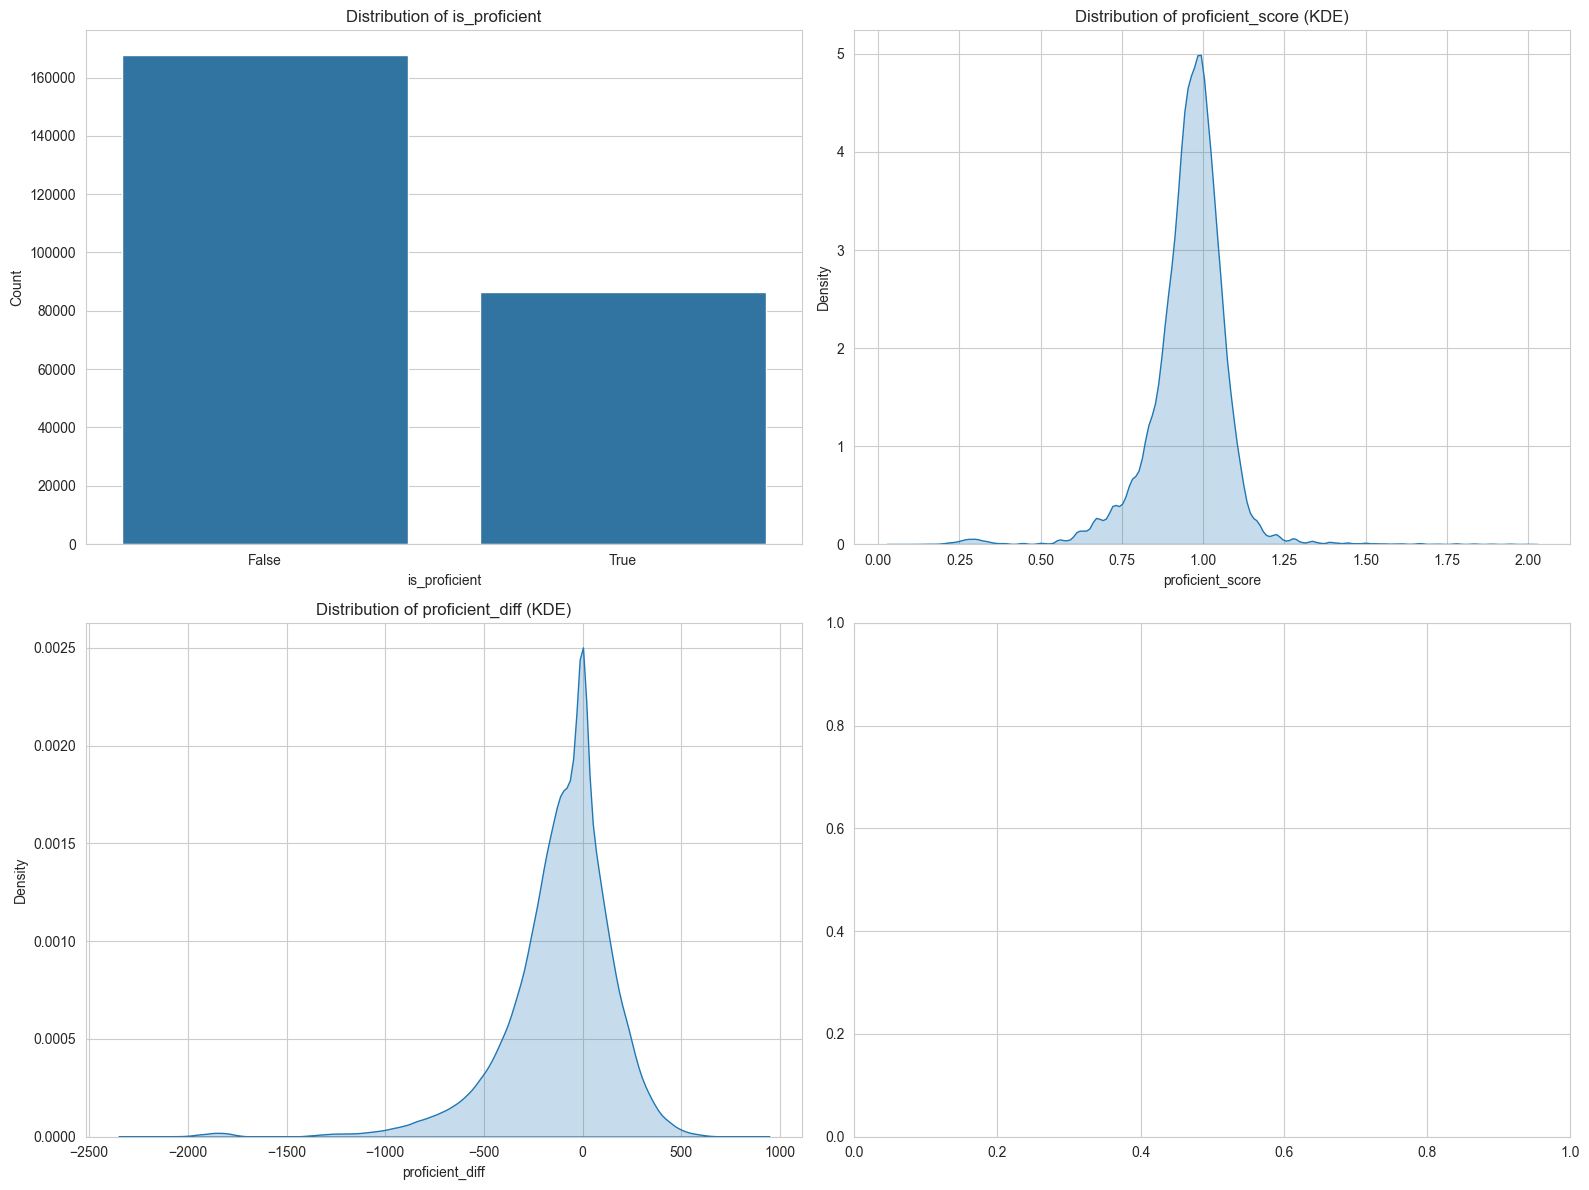


Overall Proficiency Rate: 33.99%


In [176]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Plot distribution of is_proficient
sns.countplot(x='is_proficient', data=proficiency_melted_df, ax=ax1)
ax1.set_title('Distribution of is_proficient')
ax1.set_xlabel('is_proficient')
ax1.set_ylabel('Count')

# Plot distribution of proficient_score with KDE
sns.kdeplot(data=proficiency_melted_df['proficient_score'].dropna(), shade=True, ax=ax2)
ax2.set_title('Distribution of proficient_score (KDE)')
ax2.set_xlabel('proficient_score')
ax2.set_ylabel('Density')

# Plot distribution of proficient_score with KDE
sns.kdeplot(data=proficiency_melted_df['proficient_diff'].dropna(), shade=True, ax=ax3)
ax3.set_title('Distribution of proficient_diff (KDE)')
ax3.set_xlabel('proficient_diff')
ax3.set_ylabel('Density')

plt.tight_layout()
plt.show()

# Print proficiency rate
proficiency_rate = proficiency_melted_df['is_proficient'].mean() * 100
print(f"\nOverall Proficiency Rate: {proficiency_rate:.2f}%")

In [177]:
# Step 8: Pivot the result back to wide format
proficiency_df = proficiency_melted_df.pivot_table(
    index=['studentId', 'level', 'year'],
    columns='dataSource',
    values='is_proficient'
)

# Reset the index to make 'studentId', 'level', and 'year' regular columns
proficiency_df.reset_index(inplace=True)

# Rename columns to indicate they are proficiency indicators
proficiency_df.rename(
    columns=lambda x: f'proficient_{x}' if x not in ['studentId', 'level', 'year'] else x,
    inplace=True
)

# Merge the proficiency indicators back with the original scores_df
proficiency_df = pd.merge(scores_df, proficiency_df, 
                    left_on=['studentId', 'studentLevel', 'year'],
                    right_on=['studentId', 'level', 'year'],
                    how='left')

# Remove the redundant 'level' column from the merge
proficiency_df.drop('level', axis=1, inplace=True)

# Display the first few rows of the resulting DataFrame
proficiency_df.head()

,studentId,studentLevel,year,measurementTypeId,subgroup_specialEd,subgroup_lunchStatus,subgroup_gender,subgroup_ethnicity,subgroup_ell,subgroup_bottom25,value_actMathScore,value_actEnglishScore,value_actReadingScore,value_actScienceScore,value_actCompositeScore,value_nweaMath,value_nweaReading,value_nweaEnglish,value_iReadyMath,value_iReadyReading,value_actMasteryComposite,value_actMasteryReading,value_actMasteryMath,value_actMasteryScience,value_actMasteryEnglish,value_nweaELA,value_scantronMath,value_scantronReading,value_mapMath,value_mapEnglish,value_mapReading,value_mapRLA,value_scantronScience,value_scantronLanguage,value_ReadingFoundations,value_scantronAlgebra,value_eocMath,value_actELAScore,value_mapScience,value_LeapELAScale,value_LeapMathScale,value_LeapALScale,value_LeapE2Scale,value_LeapGmScale,value_LeapBlScale,value_LeapE3Scale,value_LeapUsScale,value_E1Scale,value_UsEsScale,value_accessReadingScale,value_accessReadingProficiency,value_accessCompositeScale,value_accesscompositeProficiency,value_dibelsReading,value_mapHistory,value_LEAPSocSci,value_scantronGeometry,value_MathMilestones,value_ELAMilestones,value_starReading,value_starMath,value_ScienceMilestones,value_LEAPScience,value_SocialMilestones,value_gcaInfo,value_gcaNar,value_gcaOpin,value_aimsWebMath,value_aimsWebReading,proficient_value_actCompositeScore,proficient_value_actEnglishScore,proficient_value_actMathScore,proficient_value_actReadingScore,proficient_value_actScienceScore,proficient_value_scantronMath,proficient_value_scantronReading,proficient_value_starMath
0,44774,9,2018,6,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,44774,8,2017,6,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2841.0,2950,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,0.5,0.0,NaN
2,44774,8,2017,4,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2808.0,2936,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,0.5,0.0,NaN
3,44775,8,2017,4,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2580.0,2660,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN
4,44775,8,2017,6,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2705.0,2670,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN


# act_11

In [192]:
act_11_df = proficiency_melted_df[proficiency_melted_df['level'] == 11]

# Merge subgroup columns from scores_df into act_11_df
subgroup_columns = ['subgroup_specialEd', 'subgroup_lunchStatus', 'subgroup_gender', 'subgroup_ethnicity', 'subgroup_ell', 'subgroup_bottom25']
act_11_df = act_11_df.merge(scores_df[['studentId'] + subgroup_columns], on='studentId', how='left')

act_11_df.head()

,studentId,level,year,dataSource,score,value,is_proficient,proficient_score,proficient_diff,subgroup_specialEd,subgroup_lunchStatus,subgroup_gender,subgroup_ethnicity,subgroup_ell,subgroup_bottom25
0,45054,11,2018,value_actMathScore,9.0,17.0,False,0.529412,-8.0,0,0,0,0,0,0
1,45054,11,2018,value_actMathScore,9.0,17.0,False,0.529412,-8.0,0,0,0,0,0,0
2,45440,11,2018,value_actMathScore,16.0,17.0,False,0.941176,-1.0,0,0,0,0,0,0
3,45440,11,2018,value_actMathScore,16.0,17.0,False,0.941176,-1.0,0,0,0,0,0,0
4,45440,11,2018,value_actMathScore,16.0,17.0,False,0.941176,-1.0,0,0,0,0,0,0


Dropped subgroups columns after plotting distributions.

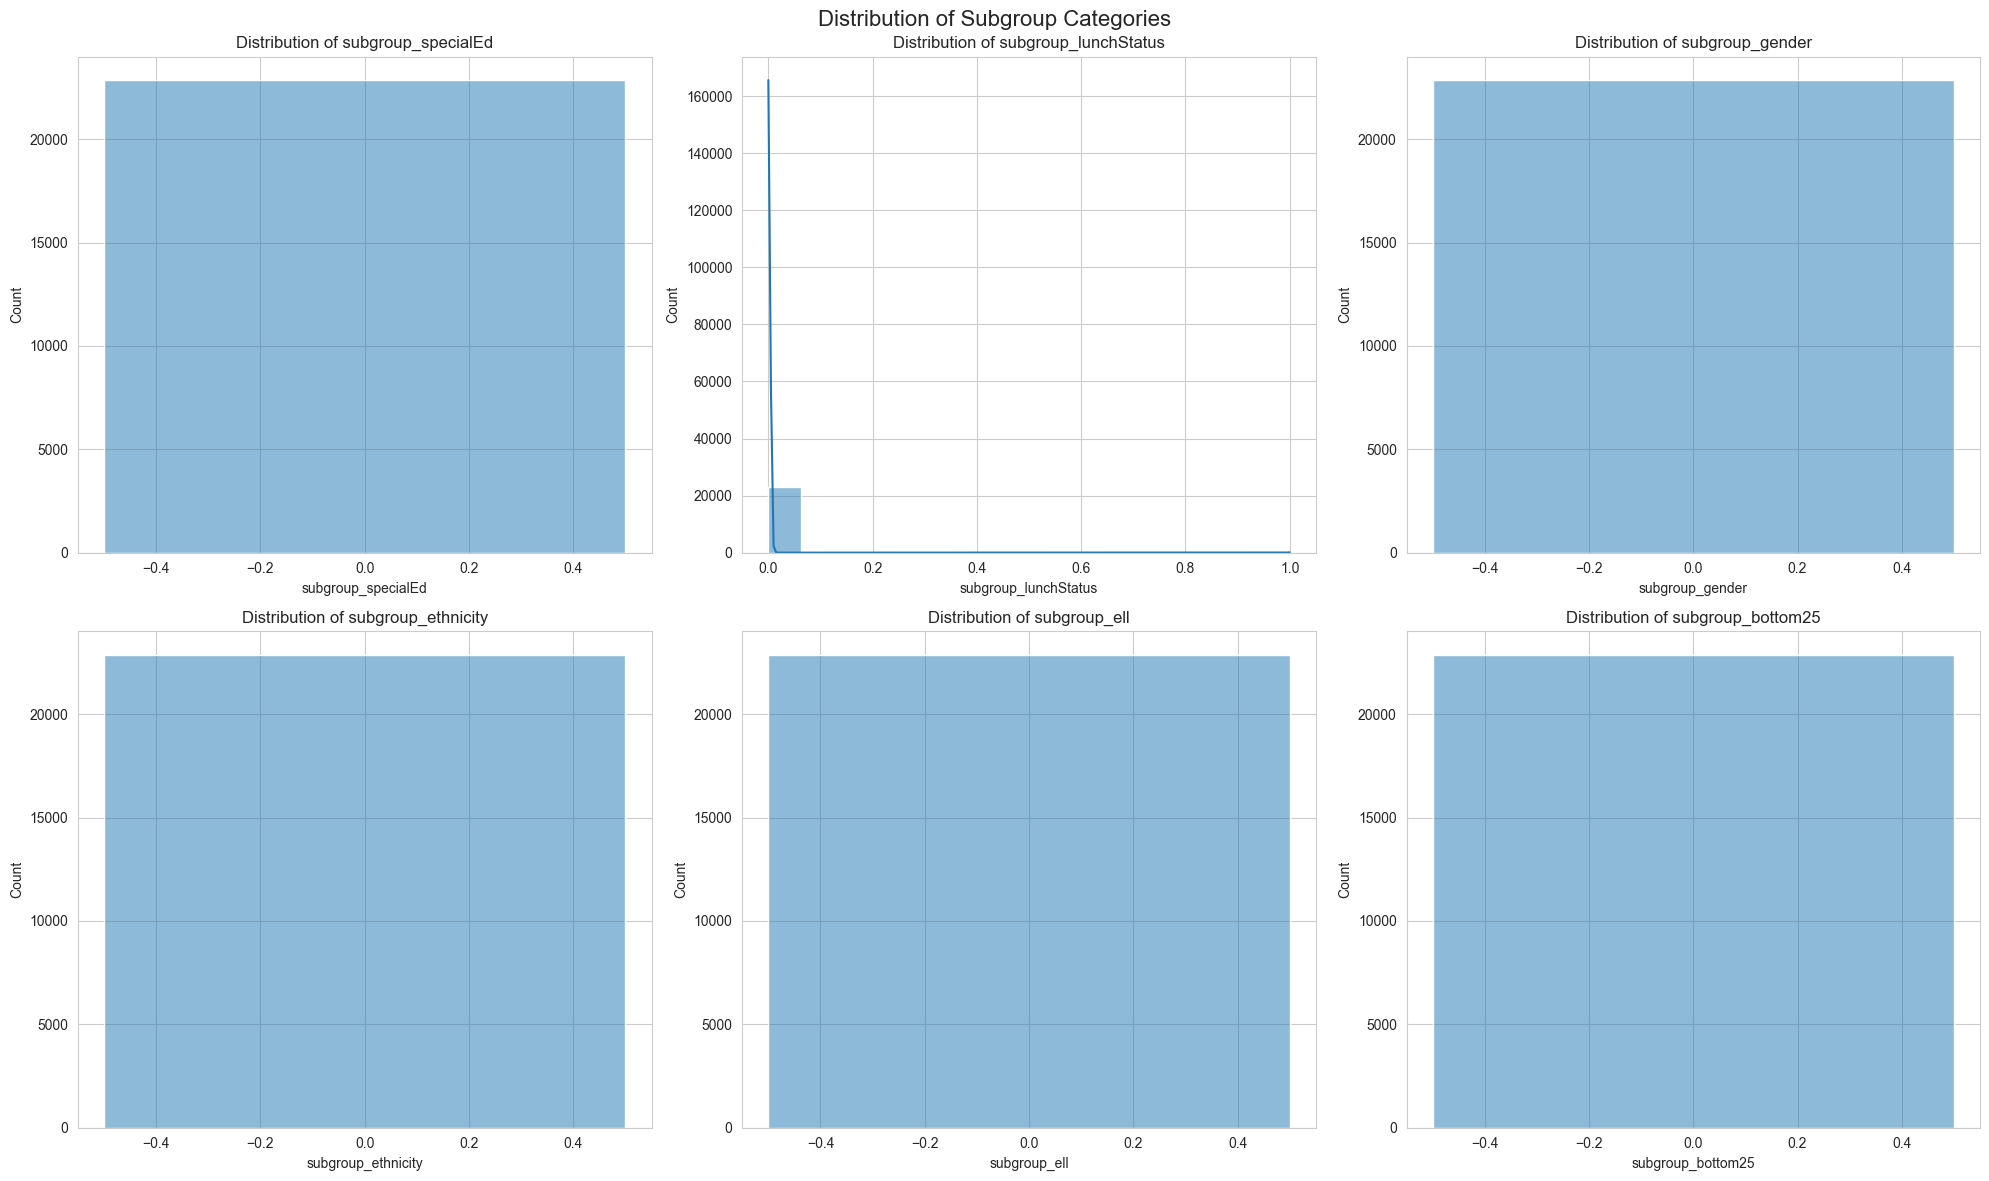


Value counts for subgroup_specialEd:
subgroup_specialEd
0    22862
Name: count, dtype: int64

--------------------------------------------------

Value counts for subgroup_lunchStatus:
subgroup_lunchStatus
0    22847
1       15
Name: count, dtype: int64

--------------------------------------------------

Value counts for subgroup_gender:
subgroup_gender
0    22862
Name: count, dtype: int64

--------------------------------------------------

Value counts for subgroup_ethnicity:
subgroup_ethnicity
0    22862
Name: count, dtype: int64

--------------------------------------------------

Value counts for subgroup_ell:
subgroup_ell
0    22862
Name: count, dtype: int64

--------------------------------------------------

Value counts for subgroup_bottom25:
subgroup_bottom25
0    22862
Name: count, dtype: int64

--------------------------------------------------


In [193]:
# Define the subgroup columns
subgroups = ['subgroup_specialEd', 'subgroup_lunchStatus', 'subgroup_gender', 
                    'subgroup_ethnicity', 'subgroup_ell', 'subgroup_bottom25']

# Set up the plot
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Distribution of Subgroup Categories', fontsize=16)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot histograms for each subgroup
for i, column in enumerate(subgroups):
    sns.histplot(data=act_11_df, x=column, ax=axes[i], kde=True)
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Count')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Print value counts for each subgroup
for column in subgroups:
    print(f"\nValue counts for {column}:")
    print(act_11_df[column].value_counts(dropna=False))
    print("\n" + "-"*50)


In [194]:
act_11_df.drop(columns=subgroups, inplace=True)

Merge with courses taken by same students in previous year (2017, grade 10).

In [195]:
courses_act_df = courses[(courses['year'] == 2017) & (courses['studentLevel'] == 10)]
courses_act_df = courses_act_df.reset_index(drop=True)

In [196]:
courses_act_df.head()

,courseSectionId,studentId,studentLevel,vanityId,year,schoolId
0,73319,46413,10,W H 1500-P,2017,224
1,73320,47091,10,Biology,2017,224
2,73321,46413,10,Enviro Sci,2017,224
3,73322,46705,10,Enviro Sci,2017,224
4,73327,50738,10,LIFE PE 9-12,2017,224


In [197]:
act_11_courses = act_11_df.merge(courses_act_df[['vanityId', 'schoolId', 'studentId']], on='studentId', how='left')

# Create binary features for each unique course vanityId
course_dummies = pd.get_dummies(act_11_courses['vanityId'], prefix='course')

# Aggregate the binary features and schoolId by studentId
act_11_courses_grouped = pd.concat([course_dummies, act_11_courses[['studentId', 'schoolId']]], axis=1)
act_11_courses_grouped = act_11_courses_grouped.groupby('studentId').agg({
    **{col: 'max' for col in course_dummies.columns},
    'schoolId': 'first'  # Take the first non-null schoolId for each student
})

# Merge the binary course features and schoolId back to act_11_df
act_11_df = act_11_df.merge(act_11_courses_grouped, on='studentId', how='left')

# Fill NaN values with 0 for course features (students not enrolled in a course)
course_columns = [col for col in act_11_df.columns if col.startswith('course_')]
act_11_df[course_columns] = act_11_df[course_columns].fillna(0)

# Merge act_11_df with schools_df to get school names
act_11_df = act_11_df.merge(schools_df[['id', 'name']], left_on='schoolId', right_on='id', how='left')

# Rename the 'name' column to 'school'
act_11_df = act_11_df.rename(columns={'name': 'school'})

# Drop the 'id' and 'schoolId' columns
act_11_df = act_11_df.drop(['id', 'schoolId'], axis=1)

In [198]:
act_11_df.head()

,studentId,level,year,dataSource,score,value,is_proficient,proficient_score,proficient_diff,course_ACT Review,course_ACT/WK Rev.,course_ACTReview.5C,course_AG Communica,course_AIDE-ELEM,course_AIDE-LIB,course_ALG I B ACCE,course_ALIITRIGH/A,course_ARMY LET I,course_ARMY LET II,course_ARMY LET III,course_ARMY LET IV,course_ARMYLETIVACT,course_AcAdv.Baseba,course_AcAdv.Basket,course_AcAdv.CrossC,course_AcAdv.Footb,course_AcAdv.Softba,course_AcAdv.Volley,course_Accounting,course_Adv BTA,course_Advanced Agr,course_Agriscience,course_Alg Esntls B,course_Alg II/Trig,course_AlgEnrichmet,course_AlgII/TrigAC,course_Algebra I,course_Algebra I A,course_Algebra I B,course_Algebra II,course_AlgebraicCon,course_Anat/Physio,course_Anthropology,course_Art App,course_BAND MARCH,course_BANDCONCERT,course_BANDMARCHAUX,course_BIOLOGY ADV,course_Bak & Pstr A,course_BandConcer.5,course_BandConcer1C,course_BandMarch.5C,course_BandSymph 1C,course_Biology,course_Biology Adv,course_BullBogAdv,course_BulldogAdvi,course_Bus Finance,course_Bus Tech App,course_CABINETMAK I,course_CABINETMAKII,course_Cabntmkng I,course_Cabntmkng II,course_Career Prep,course_CareerPrep-A,course_CareerPrep-B,course_Chemistry,course_ChemistryAdv,course_Const Fin In,course_Const Frmng,course_ContempIss1C,course_Crea Writing,course_CreatWrt.5C,course_Credit Recov,course_Culinary I,course_Culinary II,course_D&TSafetyEd,course_DRIVERS ED,course_Dance 9-12,course_Digitl Dsgn,course_ESLEnrich912,course_ESLLang9-12,course_Ear/SpaceSci,course_Eng Ess 10,course_Eng Ess 11,course_Eng Gr10 Adv,course_EngGr9-CR,"course_EngLang,BS10",course_EnglGr10ACCE,course_English Gr 9,course_English Gr10,course_English Gr11,course_Enrichmt6-12,course_Enviro Sci,course_Ess II:USHis,course_Ess: E & SS,course_Ess: Phy Sci,course_EssIII:USHis,course_EssPhySci,course_EventPlan,course_FACS,course_FAM CON SC,course_Fit Life .5C,course_Fit/Cond,course_Food Inno,course_Food Nutritn,course_For/Cri Inve,course_Forestry,course_Found AAVTC,course_FrenchIACCE,course_Fund Agrisci,course_GEOM ADV,course_Geo Ess,course_Geometry,course_Geometry Adv,course_GeometryACCE,course_German1ACCES,course_Guitar,course_HEALTH 9-12,course_HEALTH ACCES,course_HISTUS1877AC,course_HS US 10 ADV,course_Health 9-12,course_HealthACCESS,course_Hosp Tourism,course_INFO SUP SVC,course_IT Fndamntls,course_IT Supp/Serv,course_Inet Mktg,course_Int Ad Desgn,course_Int Metl Fab,course_Inter Drftng,course_Intermed Agr,course_Intr Fire Sc,course_Intro Drftng,course_Jazz 1C,course_Journal1ACC,course_Journalism 1,course_LATIN 1 ACC,course_LAW IN SOCIE,course_LIFE PE 9-12,course_LIFEPE9-12.5,course_MARKET PRIN,course_MarchAux.5C,course_MarchAux1C,course_Marine Sci,course_Mktng Prin,course_Mnt Lt Rpr A,course_Mnt Lt Rpr B,course_Multimed Des,course_Multimed Pub,course_Music App,course_MusicTheatre,course_MusicTherI.5,course_MusicThry AP,course_MusicalDrama,course_Mustang Advi,course_NCCER ET1,course_NCCER ET2,course_NCCER Wldg1,course_NCCER Wldg2,course_Painting,course_Panther Adv,course_Per Finance,course_Percuss 1C,course_Phy Sci Adv,course_PhySciACCESS,course_Physical Sci,course_Piano .5C,course_Plumb/Pipe I,course_Plumb/PipeII,course_Prn Pub Serv,course_Psyc AP Acc,course_PsychACCESS,course_Psycholog.5C,course_Psychology,course_R/DinPhysics,course_RdIntrv7-12,course_Robotics App,course_SPAN II ACCE,course_SPANISH I,course_SPANISH II,course_Sociology,course_SociologyACC,course_Span2ACCESS,course_SpanIACC,course_Spanish 1,course_Spanish 2,course_Spanish 3,course_Speech 1,course_Spo&En Mktg,course_StuAiOff912,course_StudyHall912,course_TA-Partridge,course_Tech Theater,course_Theatre I,course_Theatre II,course_TmSpts,course_TmSpts-Dance,course_Tran Serv I,course_Tran Serv II,course_TranSer 11,course_TranSer El.5,course_TranSer10,course_Travl Tour I,course_US His-1877,course_USHis 1877-P,course_USHis I Adv,course_USHis I G10,course_USHis InD-P,course_USHisIG10ACC,course_VarBkbalI,course_VarBkbalII,course_VarBsbalI,course_VarBsbalII,course_VarBsblIV,cou

Merge with schools.

In [199]:
school_dummies = pd.get_dummies(act_11_df['school'], prefix='school')
act_11_df = pd.concat([act_11_df, school_dummies], axis=1)

# Drop the original 'school' column
act_11_df = act_11_df.drop('school', axis=1)

In [200]:
act_11_df = act_11_df[act_11_df['score'] != 0]

In [201]:
act_11_df.head()

,studentId,level,year,dataSource,score,value,is_proficient,proficient_score,proficient_diff,course_ACT Review,course_ACT/WK Rev.,course_ACTReview.5C,course_AG Communica,course_AIDE-ELEM,course_AIDE-LIB,course_ALG I B ACCE,course_ALIITRIGH/A,course_ARMY LET I,course_ARMY LET II,course_ARMY LET III,course_ARMY LET IV,course_ARMYLETIVACT,course_AcAdv.Baseba,course_AcAdv.Basket,course_AcAdv.CrossC,course_AcAdv.Footb,course_AcAdv.Softba,course_AcAdv.Volley,course_Accounting,course_Adv BTA,course_Advanced Agr,course_Agriscience,course_Alg Esntls B,course_Alg II/Trig,course_AlgEnrichmet,course_AlgII/TrigAC,course_Algebra I,course_Algebra I A,course_Algebra I B,course_Algebra II,course_AlgebraicCon,course_Anat/Physio,course_Anthropology,course_Art App,course_BAND MARCH,course_BANDCONCERT,course_BANDMARCHAUX,course_BIOLOGY ADV,course_Bak & Pstr A,course_BandConcer.5,course_BandConcer1C,course_BandMarch.5C,course_BandSymph 1C,course_Biology,course_Biology Adv,course_BullBogAdv,course_BulldogAdvi,course_Bus Finance,course_Bus Tech App,course_CABINETMAK I,course_CABINETMAKII,course_Cabntmkng I,course_Cabntmkng II,course_Career Prep,course_CareerPrep-A,course_CareerPrep-B,course_Chemistry,course_ChemistryAdv,course_Const Fin In,course_Const Frmng,course_ContempIss1C,course_Crea Writing,course_CreatWrt.5C,course_Credit Recov,course_Culinary I,course_Culinary II,course_D&TSafetyEd,course_DRIVERS ED,course_Dance 9-12,course_Digitl Dsgn,course_ESLEnrich912,course_ESLLang9-12,course_Ear/SpaceSci,course_Eng Ess 10,course_Eng Ess 11,course_Eng Gr10 Adv,course_EngGr9-CR,"course_EngLang,BS10",course_EnglGr10ACCE,course_English Gr 9,course_English Gr10,course_English Gr11,course_Enrichmt6-12,course_Enviro Sci,course_Ess II:USHis,course_Ess: E & SS,course_Ess: Phy Sci,course_EssIII:USHis,course_EssPhySci,course_EventPlan,course_FACS,course_FAM CON SC,course_Fit Life .5C,course_Fit/Cond,course_Food Inno,course_Food Nutritn,course_For/Cri Inve,course_Forestry,course_Found AAVTC,course_FrenchIACCE,course_Fund Agrisci,course_GEOM ADV,course_Geo Ess,course_Geometry,course_Geometry Adv,course_GeometryACCE,course_German1ACCES,course_Guitar,course_HEALTH 9-12,course_HEALTH ACCES,course_HISTUS1877AC,course_HS US 10 ADV,course_Health 9-12,course_HealthACCESS,course_Hosp Tourism,course_INFO SUP SVC,course_IT Fndamntls,course_IT Supp/Serv,course_Inet Mktg,course_Int Ad Desgn,course_Int Metl Fab,course_Inter Drftng,course_Intermed Agr,course_Intr Fire Sc,course_Intro Drftng,course_Jazz 1C,course_Journal1ACC,course_Journalism 1,course_LATIN 1 ACC,course_LAW IN SOCIE,course_LIFE PE 9-12,course_LIFEPE9-12.5,course_MARKET PRIN,course_MarchAux.5C,course_MarchAux1C,course_Marine Sci,course_Mktng Prin,course_Mnt Lt Rpr A,course_Mnt Lt Rpr B,course_Multimed Des,course_Multimed Pub,course_Music App,course_MusicTheatre,course_MusicTherI.5,course_MusicThry AP,course_MusicalDrama,course_Mustang Advi,course_NCCER ET1,course_NCCER ET2,course_NCCER Wldg1,course_NCCER Wldg2,course_Painting,course_Panther Adv,course_Per Finance,course_Percuss 1C,course_Phy Sci Adv,course_PhySciACCESS,course_Physical Sci,course_Piano .5C,course_Plumb/Pipe I,course_Plumb/PipeII,course_Prn Pub Serv,course_Psyc AP Acc,course_PsychACCESS,course_Psycholog.5C,course_Psychology,course_R/DinPhysics,course_RdIntrv7-12,course_Robotics App,course_SPAN II ACCE,course_SPANISH I,course_SPANISH II,course_Sociology,course_SociologyACC,course_Span2ACCESS,course_SpanIACC,course_Spanish 1,course_Spanish 2,course_Spanish 3,course_Speech 1,course_Spo&En Mktg,course_StuAiOff912,course_StudyHall912,course_TA-Partridge,course_Tech Theater,course_Theatre I,course_Theatre II,course_TmSpts,course_TmSpts-Dance,course_Tran Serv I,course_Tran Serv II,course_TranSer 11,course_TranSer El.5,course_TranSer10,course_Travl Tour I,course_US His-1877,course_USHis 1877-P,course_USHis I Adv,course_USHis I G10,course_USHis InD-P,course_USHisIG10ACC,course_VarBkbalI,course_VarBkbalII,course_VarBsbalI,course_VarBsbalII,course_VarBsblIV,cou

Merge in vendorUsage.

In [202]:
vendorUsage_2017_df = vendorUsage_df[vendorUsage_df['year'] == 2017]
vendorUsage_2017_df.drop(columns=['year'], inplace=True)
vendorUsage_2017_df.reset_index(drop=True, inplace=True)
vendorUsage_2017_df.head()

/var/folders/w3/z8qntdcx62v2qmj6z9fwfhrh0000gp/T/ipykernel_3497/3338933051.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vendorUsage_2017_df.drop(columns=['year'], inplace=True)


,studentId,iready_math,iready_reading,bbb_literacy
0,119353,2,2,0
1,119371,2,2,0
2,119372,2,2,0
3,119373,2,2,0
4,119413,0,2,0


In [203]:
act_11_df = act_11_df.merge(vendorUsage_2017_df, on='studentId', how='left')
act_11_df = act_11_df.fillna(0)
to_int = ['iready_math', 'iready_reading', 'bbb_literacy']
for col in to_int:
    act_11_df[col] = act_11_df[col].astype(int)
act_11_df.head()

,studentId,level,year,dataSource,score,value,is_proficient,proficient_score,proficient_diff,course_ACT Review,course_ACT/WK Rev.,course_ACTReview.5C,course_AG Communica,course_AIDE-ELEM,course_AIDE-LIB,course_ALG I B ACCE,course_ALIITRIGH/A,course_ARMY LET I,course_ARMY LET II,course_ARMY LET III,course_ARMY LET IV,course_ARMYLETIVACT,course_AcAdv.Baseba,course_AcAdv.Basket,course_AcAdv.CrossC,course_AcAdv.Footb,course_AcAdv.Softba,course_AcAdv.Volley,course_Accounting,course_Adv BTA,course_Advanced Agr,course_Agriscience,course_Alg Esntls B,course_Alg II/Trig,course_AlgEnrichmet,course_AlgII/TrigAC,course_Algebra I,course_Algebra I A,course_Algebra I B,course_Algebra II,course_AlgebraicCon,course_Anat/Physio,course_Anthropology,course_Art App,course_BAND MARCH,course_BANDCONCERT,course_BANDMARCHAUX,course_BIOLOGY ADV,course_Bak & Pstr A,course_BandConcer.5,course_BandConcer1C,course_BandMarch.5C,course_BandSymph 1C,course_Biology,course_Biology Adv,course_BullBogAdv,course_BulldogAdvi,course_Bus Finance,course_Bus Tech App,course_CABINETMAK I,course_CABINETMAKII,course_Cabntmkng I,course_Cabntmkng II,course_Career Prep,course_CareerPrep-A,course_CareerPrep-B,course_Chemistry,course_ChemistryAdv,course_Const Fin In,course_Const Frmng,course_ContempIss1C,course_Crea Writing,course_CreatWrt.5C,course_Credit Recov,course_Culinary I,course_Culinary II,course_D&TSafetyEd,course_DRIVERS ED,course_Dance 9-12,course_Digitl Dsgn,course_ESLEnrich912,course_ESLLang9-12,course_Ear/SpaceSci,course_Eng Ess 10,course_Eng Ess 11,course_Eng Gr10 Adv,course_EngGr9-CR,"course_EngLang,BS10",course_EnglGr10ACCE,course_English Gr 9,course_English Gr10,course_English Gr11,course_Enrichmt6-12,course_Enviro Sci,course_Ess II:USHis,course_Ess: E & SS,course_Ess: Phy Sci,course_EssIII:USHis,course_EssPhySci,course_EventPlan,course_FACS,course_FAM CON SC,course_Fit Life .5C,course_Fit/Cond,course_Food Inno,course_Food Nutritn,course_For/Cri Inve,course_Forestry,course_Found AAVTC,course_FrenchIACCE,course_Fund Agrisci,course_GEOM ADV,course_Geo Ess,course_Geometry,course_Geometry Adv,course_GeometryACCE,course_German1ACCES,course_Guitar,course_HEALTH 9-12,course_HEALTH ACCES,course_HISTUS1877AC,course_HS US 10 ADV,course_Health 9-12,course_HealthACCESS,course_Hosp Tourism,course_INFO SUP SVC,course_IT Fndamntls,course_IT Supp/Serv,course_Inet Mktg,course_Int Ad Desgn,course_Int Metl Fab,course_Inter Drftng,course_Intermed Agr,course_Intr Fire Sc,course_Intro Drftng,course_Jazz 1C,course_Journal1ACC,course_Journalism 1,course_LATIN 1 ACC,course_LAW IN SOCIE,course_LIFE PE 9-12,course_LIFEPE9-12.5,course_MARKET PRIN,course_MarchAux.5C,course_MarchAux1C,course_Marine Sci,course_Mktng Prin,course_Mnt Lt Rpr A,course_Mnt Lt Rpr B,course_Multimed Des,course_Multimed Pub,course_Music App,course_MusicTheatre,course_MusicTherI.5,course_MusicThry AP,course_MusicalDrama,course_Mustang Advi,course_NCCER ET1,course_NCCER ET2,course_NCCER Wldg1,course_NCCER Wldg2,course_Painting,course_Panther Adv,course_Per Finance,course_Percuss 1C,course_Phy Sci Adv,course_PhySciACCESS,course_Physical Sci,course_Piano .5C,course_Plumb/Pipe I,course_Plumb/PipeII,course_Prn Pub Serv,course_Psyc AP Acc,course_PsychACCESS,course_Psycholog.5C,course_Psychology,course_R/DinPhysics,course_RdIntrv7-12,course_Robotics App,course_SPAN II ACCE,course_SPANISH I,course_SPANISH II,course_Sociology,course_SociologyACC,course_Span2ACCESS,course_SpanIACC,course_Spanish 1,course_Spanish 2,course_Spanish 3,course_Speech 1,course_Spo&En Mktg,course_StuAiOff912,course_StudyHall912,course_TA-Partridge,course_Tech Theater,course_Theatre I,course_Theatre II,course_TmSpts,course_TmSpts-Dance,course_Tran Serv I,course_Tran Serv II,course_TranSer 11,course_TranSer El.5,course_TranSer10,course_Travl Tour I,course_US His-1877,course_USHis 1877-P,course_USHis I Adv,course_USHis I G10,course_USHis InD-P,course_USHisIG10ACC,course_VarBkbalI,course_VarBkbalII,course_VarBsbalI,course_VarBsbalII,course_VarBsblIV,cou

Split into subject scores.

In [205]:
act_11_df['dataSource'].value_counts()

dataSource
value_actCompositeScore    7516
value_actMathScore         3837
value_actEnglishScore      3837
value_actScienceScore      3837
value_actReadingScore      3835
Name: count, dtype: int64

In [206]:
# Drop level, year, (same for all rows) and score, value (captured in label)
columns_to_drop = ['level', 'year', 'score', 'value']
act_11_df.drop(columns=[col for col in columns_to_drop if col in act_11_df.columns], inplace=True)

In [207]:
actMath_11_df = act_11_df[act_11_df['dataSource'] == 'value_actMathScore']
actReading_11_df = act_11_df[act_11_df['dataSource'] == 'value_actReadingScore']
actScience_11_df = act_11_df[act_11_df['dataSource'] == 'value_actScienceScore']
actEnglish_11_df = act_11_df[act_11_df['dataSource'] == 'value_actEnglishScore']

In [208]:
for subject in ['Math', 'Reading', 'Science', 'English']:
    df_name = f'act{subject}_11_df'
    df = locals()[df_name]
    new_df = df.drop(columns=['dataSource'])
    locals()[df_name] = new_df


actMath_11_df.to_csv('dataframes/actMath_11.csv', index=False)
actReading_11_df.to_csv('dataframes/actReading_11.csv', index=False)
actScience_11_df.to_csv('dataframes/actScience_11.csv', index=False)
actEnglish_11_df.to_csv('dataframes/actEnglish_11.csv', index=False)